<a href="https://colab.research.google.com/github/lkshiel/EPA_Projects/blob/main/Anaerobic_ModelTesting%26Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Initializing Condacolab
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


### Install packagess

In [ ]:
!pip install pandas
!pip install seaborn
!pip install rdkit

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
enumerator = rdMolStandardize.TautomerEnumerator()

from rdkit.Chem import PandasTools

import warnings
warnings.filterwarnings('ignore')

# Functions

In [ ]:
def GetCanonicalTautomer(df):
    #read in data file
    #df=pd.read_excel(file)

    #abbreviate RDKit method path
    enumerator = rdMolStandardize.TautomerEnumerator()
    uncharger = rdMolStandardize.Uncharger()

    #make empty lsit to store standard smiles
    par=[]
    prod=[]

    #loop through parent smiles, convert them to canonical format, save them to list
    for i in df['Parent_SMILES']:
        mol=i.replace('/','').replace('\\','').replace('@','')
        mol= Chem.MolFromSmiles(mol)
        uncharged_mol = uncharger.uncharge(mol)
        cmol=enumerator.Canonicalize(uncharged_mol)
        par.append((Chem.MolToSmiles(cmol)))

    #loop through product smiles, convert them to canonical format, save them to list
    for j in df['Product_SMILES']:
        if j is not np.nan:
            m=j.replace('/','').replace('\\','').replace('@','')
            m=Chem.MolFromSmiles(m)
            if m is not None:
                uncharged_m = uncharger.uncharge(m)
                cmol2=enumerator.Canonicalize(uncharged_m)
                prod.append((Chem.MolToSmiles(cmol2)))
            else:
                prod.append('FIX')
        else:
            prod.append('NA')


    #make new columns in dataframe and add the canonical formats for parent and product smiles
    df['std_Parent_SMILES']=par
    df['std_Product_SMILES']=prod

    return df

In [ ]:
#Note: This function was updated on October 17, 2024
def FullFormatPrediction(df):
    #read in data
    #df=pd.read_table(file)

    #make a new column with only product_SMILES
    df['Product_SMILES']=df.loc[df['Generation']!= 0,'#SMILES']

    # make a dictionary with parent number as key and parent smiles as value
    prnt_value=df.loc[df['Generation']==0,'#SMILES']
    prnt_key=df.loc[df['Generation']==0, 'Synthesis Code']

    prnt=dict(zip(prnt_key,prnt_value))

    #extract parent number from synthesis code and save as column 'Parent_num'
    df['Parent_ID']=df['Synthesis Code'].str.extract(r"\((\d+)\)")

    #Make new coluumn 'Inital Parent SMILES' and fill it using parent dicitonary
    df['Initial_Parent_SMILES']=df['Parent_ID'].map(prnt)

    #remove unnecessary column
    df.drop(columns=['#SMILES','name'],inplace=True)
    #remove rows with only parent smiles
    df.drop(index=df.loc[df['Generation']==0].index,inplace=True)
    #reset the index
    df.reset_index(drop=True,inplace=True)

    #seperate out reaction steps listed in 'Route' and save each step to its own column
    semi=df['Synthesis Code'].str.split((r"\((\d+)\)"),expand=True)
    steps=semi[2].str.split(':',expand=True).add_prefix('node_')

    g=df['Route'].str.split(r'(?<!\d),(?!\d)',regex=True,expand=True).add_prefix("edge_")

    for i in steps.columns:
        steps[i]=steps[i].str.split(')',expand=True)[0]

    new=pd.concat([df,steps,g],axis=1)

    new['nodeEdge_1']=np.nan
    new['nodeEdge_2']=np.nan
    new['nodeEdge_3']=np.nan
    new['nodeEdge_4']=np.nan
    for i in new.index:
        gen=new['Generation'][i]

        if gen==1:
            new['nodeEdge_1'][i]=new['edge_0'][i]+';'+ new['node_1'][i]
        elif gen==2:
            new['nodeEdge_1'][i]=new['edge_0'][i]+';'+ new['node_1'][i]
            new['nodeEdge_2'][i]=new['edge_1'][i]+';'+ new['node_2'][i]
        elif gen==3:
            new['nodeEdge_1'][i]=new['edge_0'][i]+';'+ new['node_1'][i]
            new['nodeEdge_2'][i]=new['edge_1'][i]+';'+ new['node_2'][i]
            new['nodeEdge_3'][i]=new['edge_2'][i]+';'+ new['node_3'][i]
        elif gen==4:
            new['nodeEdge_1'][i]=new['edge_0'][i]+';'+ new['node_1'][i]
            new['nodeEdge_2'][i]=new['edge_1'][i]+';'+ new['node_2'][i]
            new['nodeEdge_3'][i]=new['edge_2'][i]+';'+ new['node_3'][i]
            new['nodeEdge_4'][i]=new['edge_3'][i]+';'+ new['node_4'][i]

    path=[]
    for index,rows in new.iterrows():
        gen=new['Generation'][index]
        if gen==1:
            lst=[rows.nodeEdge_1]
            path.append(lst)
        elif gen==2:
            lst=[rows.nodeEdge_1,rows.nodeEdge_2]
            path.append(lst)
        elif gen==3:
            lst=[rows.nodeEdge_1,rows.nodeEdge_2,rows.nodeEdge_3]
            path.append(lst)
        elif gen==4:
            lst=[rows.nodeEdge_1,rows.nodeEdge_2,rows.nodeEdge_3,rows.nodeEdge_4]
            path.append(lst)
    new['PathID']=path

    new['Parent_SMILES']=np.nan
    for i in new.index:
        gen= new['Generation'][i]
        path=new['PathID'][i]
        if gen==1:
            new['Parent_SMILES'][i]=new['Initial_Parent_SMILES'][i]
        else:
            prior=new.loc[new['Generation']==(gen-1),'PathID']
            for p in prior.index:
                if list(path[:-1])==list(prior[p]):
                    new['Parent_SMILES'][i]=new['Product_SMILES'][p]

    #make a dictionary where generation is the key and a column name is the value
    gens={1:'edge_0',2:'edge_1',3:'edge_2',4:'edge_3'}
    new['Scheme']=''

    #loop that assigns immediate reaction step name to the approprate reaction in the scheme
    for i in new.index:
        gen=new['Generation'][i]
        new['Scheme'][i]=new[gens[gen]][i]

    new=new.reindex(columns=['Parent_ID','Initial_Parent_SMILES','Scheme','Parent_SMILES','Product_SMILES','PathID','Route',
                           'Synthesis Code', 'Generation', 'Phase', 'Formation', 'Degradation','Production', 'Accumulation',
                           'Exact Mass'])
    return new

In [ ]:
def GetPredCounts(table,pred):
    lst=[]

    for p in table['std_Parent_SMILES']:
        tmp=pred.loc[pred['std_Parent_SMILES']==p]
        count=len(tmp['std_Product_SMILES'].unique())
        lst.append(count)
    return lst

def GetLitCounts(table,lit):
    lst=[]

    for p in table['std_Parent_SMILES']:
        tmp=lit.loc[lit['std_Parent_SMILES']==p,'std_Product_SMILES'].dropna().unique()
        count=len(tmp[tmp!='NA'])
        lst.append(count)
    return lst

def GetEfsaCounts(table,efsa):
    lst=[]

    for p in table['std_Parent_SMILES']:
        tmp=efsa.loc[efsa['std_Parent_SMILES']==p,'std_Product_SMILES'].dropna().unique()
        count=len(tmp)
        lst.append(count)
    return lst


In [ ]:
def GetOverlap(table,pred,lit):
    laps=[]
    matches=[]

    for p in table['std_Parent_SMILES']:

    #make lists of unique products at each parent for both observed (lit) and predicted datasets
        o=list(lit.loc[lit['std_Parent_SMILES']==p,'std_Product_SMILES'].unique())
        p=list(pred.loc[pred['std_Parent_SMILES']==p,'std_Product_SMILES'].unique())

        #find SMILES that are in both observed and predicted product lists
        match=set(o).intersection(set(p))

        #save variables to list
        matches.append(list(match))

        #get the count of overlap by taking the length of match
        count=len(match)

        #save variables to list
        laps.append(count)


    return laps,matches

In [ ]:
def GetLitResults(obsL_df,pred_df):
   #make an empty dataframe to hold results
    results=pd.DataFrame()

    #Get list of parents to help with model resolution
    parents=set(set(list(pred_df['std_Parent_SMILES'])).intersection(set(list(obsL_df['std_Parent_SMILES']))))
    results['std_Parent_SMILES']=list(parents)
    lst=[]
    for p in results['std_Parent_SMILES']:
        par=lit.loc[lit['std_Parent_SMILES']==p,'Parent'].unique()[0]
        lst.append(par)
    results.insert(0,'Parent',lst)

    #remove any duplicates
    results.drop_duplicates('std_Parent_SMILES',inplace=True, ignore_index=True)

    #get prediction counts
    results['Pred_Product_Counts']=GetPredCounts(results,pred_df)

    #get observed counts
    results['Obs_Product_Counts']=GetLitCounts(results,obsL_df)
    #results['Obs_EFSAProduct_Counts']=GetEfsaCounts(results,obsE_df)

    #get product match counts and smiles
    x,y=GetOverlap(results,pred_df,obsL_df)

    results['#_of_Matches']=x
    results['Product_Overlap']=y

    return results

In [ ]:
def GetEFSAResults(obsE_df,pred_df):
   #make an empty dataframe to hold results
    results=pd.DataFrame()

    #Get list of parents to help with model resolution
    results[['Parent','std_Parent_SMILES']]=obsE_df[['Parent','std_Parent_SMILES']]

    #remove any duplicates
    results.drop_duplicates('std_Parent_SMILES',inplace=True, ignore_index=True)

    #get prediction counts
    results['Pred_Product_Counts']=GetPredCounts(results,pred_df)

    #get observed counts
    #results['Obs_LitProduct_Counts']=GetLitCounts(results,obsL_df)
    results['Obs_Product_Counts']=GetEfsaCounts(results,obsE_df)

    #get product match counts and smiles
    x,y=GetOverlap(results,pred_df,obsE_df)

    results['#_of_Matches']=x
    results['Product_Overlap']=y

    return results

## Access Google Drive to load data files

In [103]:
#access google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
#navigate to file path, check that desired file is there
!ls /content/drive/MyDrive/AnaerobicData

Anaerobic_EFSA_1gen_all_RANKED_09252024.out
Anaerobic_EFSA_1gen_RANKED_06142024.out
Anaerobic_EFSA_4gen_RANKED_06142024.out
Anaerobic_Lit_1gen_RANKED_06142024.out
Anaerobic_Lit_1gen_RANKED_06272024.out
Anaerobic_Lit_4gen_RANKED_06142024.out
AnaerobicRxn_EFSALib_90722.xlsx
AnaerobicRxn_LitLib_05072025.xlsx
EFSA_09232024.xlsx
EFSACountsTable_EX_2.1.xlsx
LitCountsTable_IN_1.1.xlsx
LitCountsTable_IN_2.1.xlsx
LitCountsTable_IN_2.4.xlsx
Updated_AnaerobicRxn_LitLib_06132024_parentType.xlsx


# Get Canonical SMILES
Edit files and path as needed

In [105]:
#read in prediction file (Metabolizer output)
PredFile=pd.read_table('/content/drive/MyDrive/AnaerobicData/Anaerobic_Lit_1gen_RANKED_06142024.out').dropna(how='all')#IN_1.1
#PredFile=pd.read_table('/content/drive/MyDrive/AnaerobicData/Anaerobic_Lit_1gen_RANKED_06272024.out').dropna(how='all')#IN_2.1
#PredFile=pd.read_table('/content/drive/MyDrive/AnaerobicData/Anaerobic_Lit_4gen_RANKED_06142024.out').dropna(how='all')#IN_2.4

#Format prediction file
p=FullFormatPrediction(PredFile)

#Get canonical SMILES for prediction file
l_pred=GetCanonicalTautomer(p)


[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Removed negative charge.
[19:02:20] Running Uncharger
[19:02:20] Removed negative charge.
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:20] Running Uncharger
[19:02:21] Tautomer enumeration stopped at 205 tautomers: max transforms reached
[19:02:21] Running Uncharger
[19:02:21] Running Uncharger
[19:02:21] Running Uncharger
[19:02:22] Tautomer enumeration stopped at 143 tautomers: max transforms reached
[19:02:22] Running Uncharger
[19:02:22] Running Uncharger
[19:02:22] Running Uncharger
[19:02:22] Running Uncharger
[19:02:22] R

In [106]:
#read in literature data
#l=pd.read_excel('/content/drive/MyDrive/AnaerobicData/AnaerobicRxn_LitLib_05072025.xlsx',sheet_name='Data') #current version of literature library
l=pd.read_excel('/content/drive/MyDrive/AnaerobicData/Updated_AnaerobicRxn_LitLib_06132024_parentType.xlsx') #version of the library that generated '06142025' results in paper

#Get canonical SMILES for literature file
lit=GetCanonicalTautomer(l)

lit=lit[lit['Parent']!='Methanol']

[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Running Uncharger
[19:03:45] Run

In [107]:
#format EFSA prediction file (Metabolizer output)
ep=FormatPrediction('/content/drive/MyDrive/AnaerobicData/Anaerobic_EFSA_1gen_all_RANKED_09252024.out')

#Get canonical SMILES for EFSA prediction file
e_pred=GetCanonicalTautomer(ep)

[19:05:57] Running Uncharger
[19:05:57] Running Uncharger
[19:05:57] Running Uncharger
[19:05:57] Running Uncharger
[19:05:57] Running Uncharger
[19:05:57] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Running Uncharger
[19:05:58] Run

In [108]:
#read in EFSA data
e=pd.read_excel('/content/drive/MyDrive/AnaerobicData/EFSA_09232024.xlsx')

#Get canonical SMILES for EFSA file
efsa=GetCanonicalTautomer(e)

[19:06:07] Running Uncharger
[19:06:07] Running Uncharger
[19:06:07] Running Uncharger
[19:06:07] Running Uncharger
[19:06:07] Running Uncharger
[19:06:07] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Running Uncharger
[19:06:08] Run

,Rxn_Scheme,Initial_Parent,Parent,Parent_DTXSID,Parent_SMILES,Product,Product_SMILES,Rxn_System,Temp (°C),pH,HalfLife (days),Reference,Notes,std_Parent_SMILES,std_Product_SMILES
0,"Ring Opening: 3-methyl-5,6-dihydro-1,4,2-dioxa...",Fluoxastrobin,Fluoxastrobin,DTXSID2034625,CO\N=C(\C1=NOCCO1)C1=C(OC2=NC=NC(OC3=CC=CC=C3C...,M38,CO\N=C(\C(N)=O)C1=C(OC2=NC=NC(OC3=CC=CC=C3Cl)=...,water sediment under anaerobic conditions,20.0,5.3,146,fluoxastrobin_DAR_06_vol3_b8_public.pdf,Transformation shown in Figure B.8.6 (pg.62/76),CON=C(C1=NOCCO1)c1ccccc1Oc1ncnc(Oc2ccccc2Cl)c1F,CON=C(C(N)=O)c1ccccc1Oc1ncnc(Oc2ccccc2Cl)c1F
1,Biotic Hydrolysis: Amide REVISED,Fluoxastrobin,M38,NaN,CO\N=C(\C(N)=O)C1=C(OC2=NC=NC(OC3=CC=CC=C3Cl)=...,M40,CO\N=C(\C(O)=O)C1=C(OC2=NC=NC(OC3=CC=CC=C3Cl)=...,NaN,NaN,NaN,NaN,fluoxastrobin_DAR_06_vol3_b8_public.pdf,Transformation shown in Figure B.8.6 (pg.62/76),CON=C(C(N)=O)c1ccccc1Oc1ncnc(Oc2ccccc2Cl)c1F,CON=C(C(=O)O)c1ccccc1Oc1ncnc(Oc2ccccc2Cl)c1F
2,Dealkylation: O-demethylation of methyl ethers,Pyroxsulam,Pyroxsulam,DTXSID7044344,COC1=NC2=NC(NS(=O)(=O)C3=C(OC)N=CC=C3C(F)(F)F)...,7-OH-XDE-742,COC1=CC(=O)N2C(=N1)N=C(N2)NS(=O)(=O)C3=C(C=CN=...,flooded soil system under anaerobic conditions...,20.0,6.2,47,pyroxsulam DAR_10_vol3_B-8.pdf,half life was reported on page 29/221; transfo...,COc1cc(OC)n2nc(NS(=O)(=O)c3c(C(F)(F)F)ccnc3OC)...,COc1cc(=O)n2[nH]c(NS(=O)(=O)c3c(C(F)(F)F)ccnc3...
3,Dealkylation: O-demethylation of methyl ethers,Pyroxsulam,7-OH-XDE-742,DTXSID0047662,COC1=CC(=O)N2NC(NS(=O)(=O)C3=C(C=CN=C3OC)C(F)(...,NaN,COC1=NC=CC(=C1S(=O)(=O)NC1=NC2=NC(O)=CC(=O)N2N...,flooded soil system under anaerobic conditions...,20.0,6.2,60,pyroxsulam DAR_10_vol3_B-8.pdf,half life was reported on page 29/221; transfo...,COc1cc(=O)n2[nH]c(NS(=O)(=O)c3c(C(F)(F)F)ccnc3...,COc1nccc(C(F)(F)F)c1S(=O)(=O)Nc1nc2[nH]c(=O)cc...
4,Reduction scheme 1,Pyroxsulam,"N-{5-hydroxy-7-oxo-1H,7H-[1,2,4]triazolo[1,5-a...",NaN,COC1=NC=CC(=C1S(=O)(=O)NC1=NC2=NC(O)=CC(=O)N2N...,NaN,COC1=NC=CC(=C1S(=O)(=O)NC1=NC2=NC(O)=CC(O)N2N1...,flooded soil system under anaerobic conditions...,20.0,6.2,NaN,pyroxsulam DAR_10_vol3_B-8.pdf,no rate data; transfomration shown in Figure ...,COc1nccc(C(F)(F)F)c1S(=O)(=O)Nc1nc2[nH]c(=O)cc...,COc1nccc(C(F)(F)F)c1S(=O)(=O)Nc1nc2n(n1)C(O)CC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,NaN,Fipronil,Fipronil,DTXSID4034609,NC1=C(C(=NN1C1=C(Cl)C=C(C=C1Cl)C(F)(F)F)C#N)S(...,Fipronil-sulfide,C1=C(C=C(C(=C1Cl)N2C(=C(C(=N2)C#N)SC(F)(F)F)N)...,Sandy Loam,25.0,7.8,166,Fipronil_DAR_11_Vol 3_B8_public.pdf,sulfoxide reduction; referred to as MB 45950,N#Cc1nn(-c2c(Cl)cc(C(F)(F)F)cc2Cl)c(N)c1S(=O)C...,N#Cc1nn(-c2c(Cl)cc(C(F)(F)F)cc2Cl)c(N)c1SC(F)(F)F
204,NaN,Dimethachlor,Dimethachlor,DTXSID3058111,COCCN(C(=O)CCl)C1=C(C)C=CC=C1C,"N-(2,6-Dimethylphenyl)-N-(2-methoxyethyl)aceta...",COCCN(C(C)=O)C1=C(C)C=CC=C1C,"silt loam, 3.5% OC, 2.57 MBq/mg/kg soil",20.0,7.5,122,Dimethachlor_DAR_08_Vol3_B8_public.pdf,"metabolite referred to as CGA 42443, reductive...",COCCN(C(=O)CCl)c1c(C)cccc1C,COCCN(C(C)=O)c1c(C)cccc1C
205,NaN,Etridiazole,Etridiazole,DTXSID3032547,CCOC1=NC(=NS1)C(Cl)(Cl)Cl,"5-Ethoxy-3-(dichloromethyl)-1,2,4-thiadiazole",CCOC1=NC(=NS1)C(Cl)Cl,"sandy loam, 2.4% OC",25.0,6.6,0.59,etridiazole_DAR_06_Vol3_B8_public.pdf,metabolite referred to as dichloro-etridiazole...,CCOc1nc(C(Cl)(Cl)Cl)ns1,CCOc1nc(C(Cl)Cl)ns1
206,NaN,Thiodicarb,Thiodicarb,DTXSID0032578,CC(=NOC(=O)N(C)SN(C)C(=O)ON=C(C)SC)SC,Acetonitrile,CC#N,"clay loam, 2% OC",20.0,7.9,0.003056,Thiodicarb_DAR_06_Vol 3_b8_public.pdf,anaerobic conditions are unlikely to occur,CSC(C)=NOC(=O)N(C)SN(C)C(=O)ON=C(C)SC,CC#N


# Results

In [109]:
#Get counts from literature/prediction data
#return in a results table
l_counts=GetLitResults(lit,l_pred)
l_counts

,Parent,std_Parent_SMILES,Pred_Product_Counts,Obs_Product_Counts,#_of_Matches,Product_Overlap
0,Tetrachloroethylene,ClC(Cl)=C(Cl)Cl,1,3,1,[ClC=C(Cl)Cl]
1,"Phenol, dimethoxy-",COc1cccc(O)c1OC,2,1,0,[]
2,Malathion,CCOC(=O)CC(SP(=S)(OC)OC)C(=O)OCC,9,3,3,"[CCOC(=O)CC(SP(O)(=S)OC)C(=O)OCC, CCOC(=O)C(CC..."
3,TCP221a/b,O=C(O)COc1ncc(Cl)cc1Cl,4,1,1,[O=c1[nH]cc(Cl)cc1Cl]
4,"2,4-diamino-6-nitrotoluene",Cc1c(N)cc(N)cc1[N+](=O)[O-],2,1,0,[]
...,...,...,...,...,...,...
296,2-({[1-(4-chlorophenyl)-1H-pyrazol-3-yl]oxy}me...,CONc1ccccc1COc1ccn(-c2ccc(Cl)cc2)n1,1,1,1,[Nc1ccccc1COc1ccn(-c2ccc(Cl)cc2)n1]
297,3-hydroxypropanal,O=CCCO,1,1,1,[O=C(O)CCO]
298,Benzylsuccinic acid,O=C(O)CC(Cc1ccccc1)C(=O)O,1,1,1,[CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncn...
299,N-ethyl perfluorooctanesulfonamido ethanols,CCN(CCO)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,1,1,1,[CCN(CC(=O)O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F...


In [110]:
#Get counts from efsa/prediction data
#return in a results table
e_counts=GetEFSAResults(efsa,e_pred)
e_counts

,Parent,std_Parent_SMILES,Pred_Product_Counts,Obs_Product_Counts,#_of_Matches,Product_Overlap
0,Fluoxastrobin,CON=C(C1=NOCCO1)c1ccccc1Oc1ncnc(Oc2ccccc2Cl)c1F,0,1,0,[]
1,M38,CON=C(C(N)=O)c1ccccc1Oc1ncnc(Oc2ccccc2Cl)c1F,2,1,1,[CON=C(C(=O)O)c1ccccc1Oc1ncnc(Oc2ccccc2Cl)c1F]
2,Pyroxsulam,COc1cc(OC)n2nc(NS(=O)(=O)c3c(C(F)(F)F)ccnc3OC)...,3,1,1,[COc1cc(=O)n2[nH]c(NS(=O)(=O)c3c(C(F)(F)F)ccnc...
3,7-OH-XDE-742,COc1cc(=O)n2[nH]c(NS(=O)(=O)c3c(C(F)(F)F)ccnc3...,2,1,1,[COc1nccc(C(F)(F)F)c1S(=O)(=O)Nc1nc2[nH]c(=O)c...
4,"N-{5-hydroxy-7-oxo-1H,7H-[1,2,4]triazolo[1,5-a...",COc1nccc(C(F)(F)F)c1S(=O)(=O)Nc1nc2[nH]c(=O)cc...,1,1,0,[]
...,...,...,...,...,...,...
159,Dimethenamid,COCC(C)N(C(=O)CCl)c1c(C)csc1C,4,1,1,[COCC(C)N(C(=O)CO)c1c(C)csc1C]
160,Dimethachlor,COCCN(C(=O)CCl)c1c(C)cccc1C,4,1,1,[COCCN(C(C)=O)c1c(C)cccc1C]
161,Etridiazole,CCOc1nc(C(Cl)(Cl)Cl)ns1,2,1,1,[CCOc1nc(C(Cl)Cl)ns1]
162,Thiodicarb,CSC(C)=NOC(=O)N(C)SN(C)C(=O)ON=C(C)SC,3,1,1,[CC#N]


In [111]:
#subset ofcount data that only includes parents with observed products
# some parents we found rates for but no products, I have left them in just in case
# but they could be deteled from input data.
l_counts=l_counts[l_counts['Obs_Product_Counts']!=0]
e_counts=e_counts[e_counts['Obs_Product_Counts']!=0]


### Functions that deal with the Co-enzyme A and other false negatives
twoStep: Parents that use scheme 'Dealkylation: O-demethylation of methyl ethers' and Bromoxynil produce their observed products in two generations of using the same scheme

coa: parents that are apart of the CoA scheme are sometimes reported as havinga Carboxylic acid group instead of CoA


modify results table to count these parents as overlap

In [112]:
def AddFalseNeg(table,obs_df):
    twoStep=['1,2-Dimethoxybenzene','1,3-Dimethoxybenzene','Hydroquinone dimethyl ether','2,6-Dimethoxyphenol','3,4,5-Trimethoxybenzoate','Phenol, dimethoxy-','Benzene, 1,2,3-trimethoxy-','Bromoxynil','Syringic acid'] #parents that produce the correct product in two steps
    coa=['Butyric acid','4-methyl-13-(4-sulfophenyl)tetradecanoic acid','Pyridine','Methyl ethyl ketone','Methyl isobutyl ketone','p-Xylene']
    for p in table.index:
        par=table['Parent'][p]
        if par in twoStep:
            table['#_of_Matches'][p]=+1
            table['Product_Overlap'][p]=obs_df.loc[obs_df['Parent']==par,'std_Product_SMILES']
        if par in coa:
            table['#_of_Matches'][p]=+1
            table['Product_Overlap'][p]=obs_df.loc[obs_df['Parent']==par,'std_Product_SMILES']
    return table

In [113]:
#final counts table
lresults=AddFalseNeg(l_counts,lit)
eresults=AddFalseNeg(e_counts,efsa)

## Save count tables as excel files
dont forget to edit the output path and file name!

In [114]:
lresults.to_excel('/content/drive/MyDrive/AnaerobicData/LitCountsTable_IN_1.1.xlsx',index=False)

In [115]:
eresults.to_excel('/content/drive/MyDrive/AnaerobicData/EFSACountsTable_EX_2.1.xlsx',index=False)

# Performance testing

In [116]:
#change out file using this line
results=pd.read_excel('/content/drive/MyDrive/AnaerobicData/LitCountsTable_IN_1.1.xlsx')

In [117]:
#get overall sums for each metric
TP=results['#_of_Matches'].sum()
TP_FN=results['Obs_Product_Counts'].sum()
TP_FP=results['Pred_Product_Counts'].sum()


#calculate sensitivity (recall) and selectivity (precision
recall=TP/TP_FN
precision=TP/TP_FP


print('Observed Product Count (TP+FN): ', TP_FN)
print('Predicted Product Count (TP+FP): ', TP_FP)
print('Overlap (TP): ',TP)

print('Recall: ', recall)
print('Precision: ', precision)

Observed Product Count (TP+FN):  381
Predicted Product Count (TP+FP):  531
Overlap (TP):  322
Recall:  0.8451443569553806
Precision:  0.6064030131826742


# Diagnostic testing

The following metrics are used to troubleshoot the library

In [64]:
#I reccommend looking at each dataset separately
#in the line below change the file name to either LitCountsTable.xlsx or EFSACountsTable.xlsx
results=pd.read_excel('/content/drive/MyDrive/AnaerobicData/LitCountsTable_IN_1.1.xlsx')

### Too many products

Metric that was helpful early on in library debelopment, but not really useful at this point

<Axes: ylabel='Frequency'>

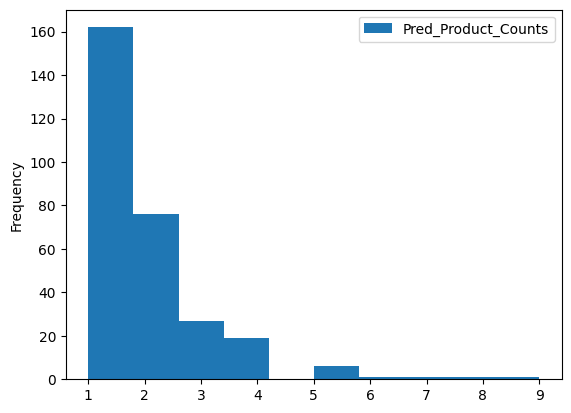

In [65]:
#plot distribution of predicted product counts
results.plot(x='Parent',y='Pred_Product_Counts',kind='hist')

In [66]:
#no parent should be predicting aboce 40 products anymore
#subset of parents producing too many products
many=list(results.loc[results['Pred_Product_Counts']>=40,'Parent'])
tooMany=lit[lit['Parent'].isin(many)==True]
results.loc[results['Pred_Product_Counts']>=40]

,Parent,std_Parent_SMILES,Pred_Product_Counts,Obs_Product_Counts,#_of_Matches,Product_Overlap


### noProd: Parents that did not predict any products


In [67]:
#Parents with no predicted products
pl=results.loc[results['Pred_Product_Counts']==0,'Parent']

noProd=lit[lit['Parent'].isin(list(pl))==True]
#noProd=efsa[efsa['Parent'].isin(list(pl))==True]
list(pl)

[]

### mismatch: parents that do predict products, but the products are incorrect

In [68]:
#mismatch
mismatch=results[(results['#_of_Matches']==0) & (results['Pred_Product_Counts']!=0)]


mm=lit[lit['Parent'].isin(list(mismatch['Parent']))==True]
#mm=efsa[efsa['Parent'].isin(list(mismatch['Parent']))==True]
mismatch

,Parent,std_Parent_SMILES,Pred_Product_Counts,Obs_Product_Counts,#_of_Matches,Product_Overlap
4,"2,4-diamino-6-nitrotoluene",Cc1c(N)cc(N)cc1[N+](=O)[O-],2,1,0,[]
48,4-Aminoimidazole,Nc1c[nH]cn1,1,1,0,[]
85,Pendimethalin,CCC(CC)Nc1c([N+](=O)[O-])cc(C)c(C)c1[N+](=O)[O-],2,1,0,[]
139,imidaclothiz,O=[N+]([O-])NC1=NCCN1Cc1cnc(Cl)s1,1,1,0,[]
161,3-hydroxypropionic acid,O=C(O)CCO,1,1,0,[]


### Save issues tables as Excel file
NOTE: I reccomend changing ouput file name if you run iterations so that previous files do not get overwritten.

In [ ]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('/content/drive/MyDrive/AnaerobicData/LitIssuesTable.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
#tooMany.to_excel(writer, sheet_name='TooManyProducts',index=False)
noProd.to_excel(writer, sheet_name='NoProducts',index=False)
mm.to_excel(writer, sheet_name='Mismatch', index=False)


# Close the Pandas Excel writer and output the Excel file.
writer.close()